In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn')
sns.set(font_scale=2)
from collections import Counter

%matplotlib inline
import torch
import torchvision
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torch
from torchvision import transforms
from PIL import Image

#CUDA 메모리 할당 / 디바이스 할당
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

C:\Users\PC\AppData\Local\Temp\ipykernel_6192\2823742555.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
a = np.load('wafer_image/WM811K.npy')
a = torch.Tensor(a)

b = np.load('wafer_image/WM811K_label.npy')
b = torch.Tensor(b)

classes = b[0].shape[1] # 8

In [3]:
# ResNet : residual block이 겹겹이 쌓여 구성된 모델
# residual block 정의

import torch.utils.data as data

class BasicDataset(data.Dataset):
  def __init__(self,data,label,transform):
    super(BasicDataset, self).__init__()
    self.data=data
    self.label=label
    self.transform=transform
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    sample_X = self.data[idx]
    sample_y = self.label[idx]
    if self.transform:
      sample_X = self.transform(sample_X)
    return sample_X, sample_y

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes = classes, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [5]:
from sklearn.model_selection import train_test_split

# train : test = 8 : 2

# Transforms 정의
# 학습 데이터용 : 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 검증 데이터용 : 정규화만 실시
transform = transforms.Compose([
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_X, test_X, train_Y, test_Y = train_test_split(a, b, train_size=0.8, random_state=42)# 셔플

# 데이터셋 생성
dataset_train = BasicDataset(train_X, train_Y, transform=transform_train)
dataset_test = BasicDataset(test_X, test_Y, transform=transform)

# OOD

In [6]:
OOD = np.load('wafer_image/Mixed_WM811K.npy')

OOD = torch.Tensor(OOD)

desired_size = (len(OOD), 1, classes)
OOD_label = torch.zeros(desired_size)

OOD_dataset = BasicDataset(OOD, OOD_label, transform = transform_train)

#----

data = torch.cat((train_X, OOD),0)
data_label = torch.cat((train_Y, OOD_label),0)

dataset=BasicDataset(data, data_label, transform=transform_train)

OOD=DataLoader(OOD, batch_size = 64)
train_loader = DataLoader(dataset_train, batch_size=64, drop_last=True)

# Model

In [7]:
model = resnet34().to(DEVICE)

args = {
	'BATCH_SIZE':64,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 10
        }

criterion = torch.nn.CrossEntropyLoss().to(DEVICE) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])
torch.manual_seed(42)

In [8]:
# 추가
class SaveBestModel:
    def __init__(
        self, best_train_loss=float('inf')
    ):
        self.best_train_loss = best_train_loss

    def __call__(
        self, current_train_loss,
        epoch, model, optimizer, criterion
    ):
        if current_train_loss < self.best_train_loss:
            self.best_train_loss = current_train_loss
            print(f"\nBest train loss: {self.best_train_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')

save_best_model = SaveBestModel()

In [9]:
# 연습용
def train_epoch(model, train_loader_in, train_loader_out, loss_fn, optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    
    #for images, labels in dataloader:
    for (in_set, out_set) in zip(train_loader_in, train_loader_out):
        data = torch.cat((in_set[0], out_set[0]), dim=0)
        target = in_set[1]
        
        data, target = data.to(DEVICE), target.to(DEVICE).reshape(args['BATCH_SIZE'], classes)
        
        # forward
        x = model(data)
        
        # backward
        optimizer.zero_grad()
        
        target = torch.argmax(target, dim = 1)
        loss = loss_fn(x[:len(in_set[0])], target)
        # cross-entropy from softmax distribution to uniform distribution
        loss += 0.5 * -(x[len(in_set[0]):].mean(1) - torch.logsumexp(x[len(in_set[0]):], dim=1)).mean()
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * target.shape[0]
        predictions = torch.argmax(x[:len(in_set[0])], 1)
        
        train_correct += (predictions == target).sum().item()
        

    return train_loss, train_correct

def test_epoch(model, dataloader, loss_fn):
    test_loss, test_correct = 0.0, 0
    model.eval()
    y_true, y_pred = [], []
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'], classes)
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss=loss_fn(output, labels)
        test_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        test_correct += (predictions == labels).sum().item()
        y_true += labels.tolist()
        y_pred += predictions.tolist()
    return test_loss, test_correct, y_true, y_pred

In [10]:
load = False # True 활용하면 model만 불러온다.
if load == False:
    train_loader_in = DataLoader(dataset_train, batch_size=args['BATCH_SIZE'], drop_last=True, shuffle = True)
    train_loader_out = DataLoader(OOD_dataset, batch_size=args['BATCH_SIZE'], drop_last = True, shuffle = True)
    history = {'train_loss': [], 'train_acc':[]}

    for epoch in range(args['NUM_EPOCH']):
      train_loss, train_correct=train_epoch(model,train_loader_in, train_loader_out, criterion,optimizer)
      train_loss = train_loss / len(train_loader_out.sampler)
      train_acc = train_correct / len(train_loader_out.sampler) * 100
    
      #print(train_correct)
      #print(len(train_loader_in.sampler))
    
      print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Training Acc: {:.2f} % ".format(epoch + 1, args['NUM_EPOCH'],train_loss ,train_acc))
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      save_best_model(
          train_loss, epoch, model, optimizer, criterion
           )
    # load best model
    checkpoint = torch.load('outputs/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # test model using test_epoch function
    test_loader = DataLoader(dataset_test, batch_size=args['BATCH_SIZE'], drop_last=True)
    test_loss, test_correct, y_true, y_pred = test_epoch(model, test_loader, criterion)

    # calculate test set accuracy and loss
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * test_correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.3f} Test Accuracy: {test_acc:.2f}%")
else:
    # load best model
    checkpoint = torch.load('outputs/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # test model using test_epoch function
    test_loader = DataLoader(dataset_test, batch_size=args['BATCH_SIZE'], drop_last=True)
    test_loss, test_correct, y_true, y_pred = test_epoch(model, test_loader, criterion)

    # calculate test set accuracy and loss
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * test_correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.3f} Test Accuracy: {test_acc:.2f}%")

Epoch:1/10 AVG Training Loss:1.617 AVG Training Acc: 75.30 % 

Best train loss: 1.616955520629883

Saving best model for epoch: 1

Epoch:2/10 AVG Training Loss:1.386 AVG Training Acc: 82.95 % 

Best train loss: 1.386085105895996

Saving best model for epoch: 2

Epoch:3/10 AVG Training Loss:1.347 AVG Training Acc: 84.36 % 

Best train loss: 1.3465246156964983

Saving best model for epoch: 3

Epoch:4/10 AVG Training Loss:1.310 AVG Training Acc: 85.56 % 

Best train loss: 1.309542135692778

Saving best model for epoch: 4

Epoch:5/10 AVG Training Loss:1.287 AVG Training Acc: 86.52 % 

Best train loss: 1.2871922454833984

Saving best model for epoch: 5

Epoch:6/10 AVG Training Loss:1.262 AVG Training Acc: 87.40 % 

Best train loss: 1.2618990685599192

Saving best model for epoch: 6

Epoch:7/10 AVG Training Loss:1.250 AVG Training Acc: 87.83 % 

Best train loss: 1.2503778428577241

Saving best model for epoch: 7

Epoch:8/10 AVG Training Loss:1.230 AVG Training Acc: 88.65 % 

Best train loss:

# Confusion Matrix

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize = 10)
    plt.yticks(tick_marks, classes,fontsize = 10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

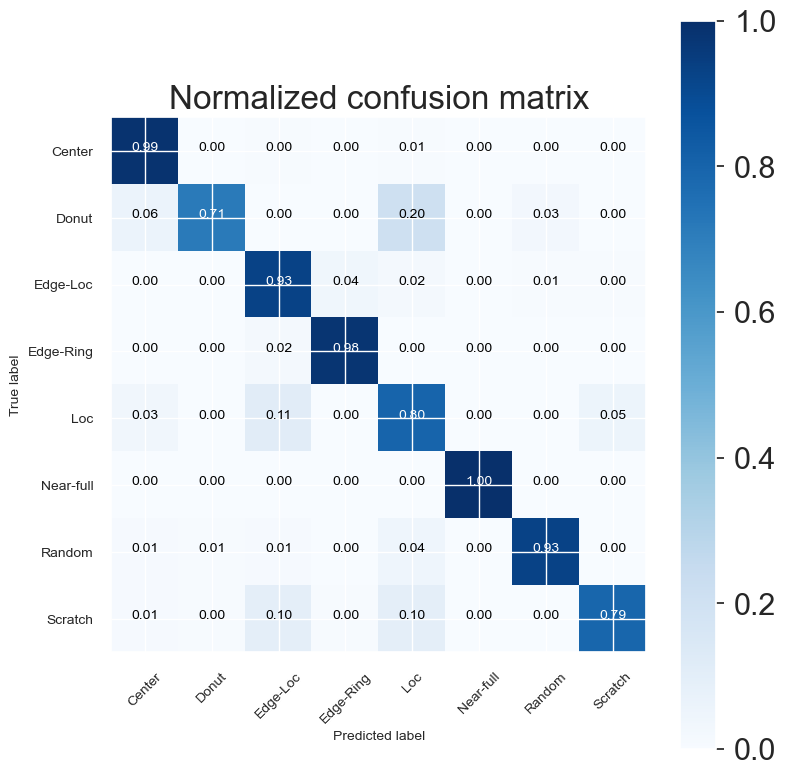

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

test_loss, test_correct, y_true, y_pred = test_epoch(model, test_loader, criterion)

cm = confusion_matrix(y_true, y_pred)
classes = [str(i) for i in range(8)]
faulty_case  =['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']


# Plot the confusion matrix with larger font size
plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 10})  # 폰트 크기 조정
plot_confusion_matrix(cm, faulty_case, normalize=True, title='Normalized confusion matrix')
plt.show()

In [13]:
sample_image = test_X

# 모델에 이미지 데이터 전달
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():  # 그라디언트 계산 비활성화
    output = model(sample_image.to(DEVICE))  # 모델에 이미지 데이터 전달

# 소프트맥스 함수를 적용하여 확률값 계산
softmax_output = torch.softmax(output, dim=1)

# 각 이미지별로 가장 큰 소프트맥스 값을 가진 값을 추출
softmax_in = torch.max(softmax_output, axis = 1).values
softmax_in.shape

torch.Size([5104])

0.460980586707592


Text(0.5, 1.0, 'In Distribution max softmax score')

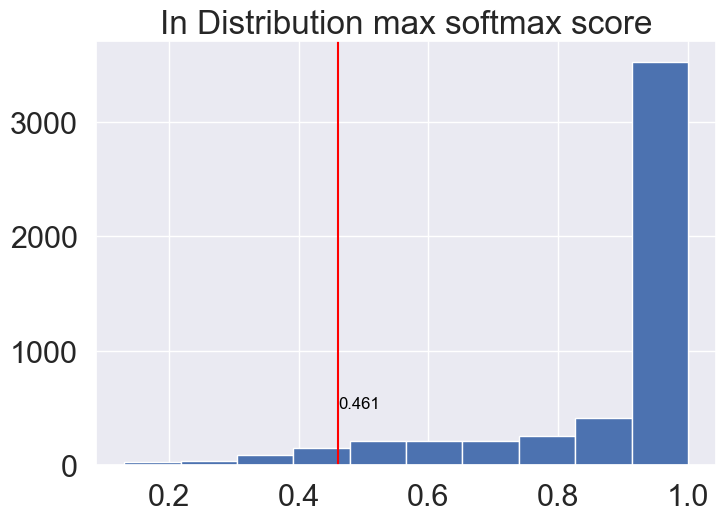

In [14]:
TPR95 = np.percentile(softmax_in.cpu().numpy(), q = 5)
print(TPR95)
plt.hist(softmax_in.cpu().numpy())
plt.axvline(x = TPR95, color = 'red')
plt.text(TPR95, 500, np.round(TPR95,3), fontsize=12, color='black')
plt.title('In Distribution max softmax score')

# Out of Distribution Data load

## 1. Mixed Donut

In [15]:
group_out = np.load('wafer_image/group_donut.npy')

group_out = torch.Tensor(group_out)

sample_image = group_out

# 모델에 이미지 데이터 전달
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():  # 그라디언트 계산 비활성화
    output = model(sample_image.to(DEVICE))  # 모델에 이미지 데이터 전달

# 소프트맥스 함수를 적용하여 확률값 계산
softmax_output = torch.softmax(output, dim=1)

predicted_classes = torch.argmax(softmax_output, dim=1).tolist()

# 각 이미지별로 가장 큰 소프트맥스 값을 가진 값을 추출
softmax_out = torch.max(softmax_output, axis = 1).values
print(softmax_out.shape)
print(Counter(predicted_classes))

torch.Size([5000])
Counter({0: 3565, 5: 604, 1: 578, 4: 168, 6: 44, 2: 40, 3: 1})


Text(0.5, 1.0, 'Mixed Donut max softmax score - FPR: 0.660')

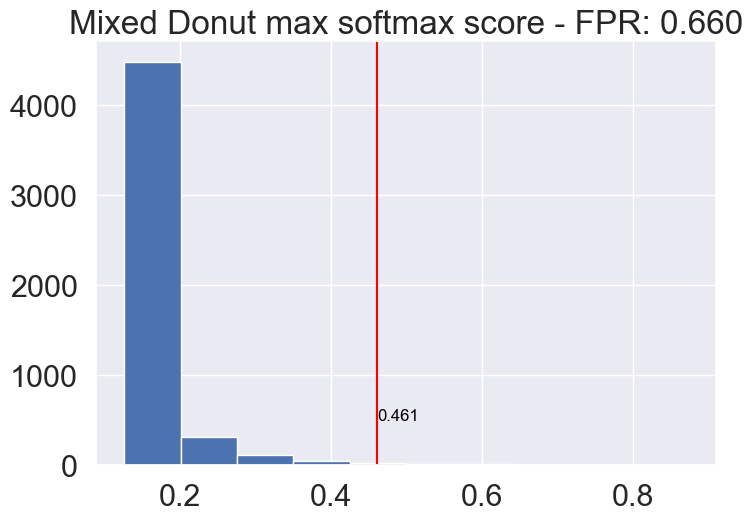

In [16]:
plt.hist(softmax_out.cpu().numpy())
plt.axvline(x = TPR95, color = 'red')
plt.text(TPR95, 500, np.round(TPR95,3), fontsize=12, color='black')
plt.title('Mixed Donut max softmax score - FPR: {:.3f}'.format(100*np.mean(softmax_out.cpu().numpy() > TPR95)))

## 2. Mixed Center

In [17]:
group_out = np.load('wafer_image/group_center.npy')

group_out = torch.Tensor(group_out)

sample_image = group_out

# 모델에 이미지 데이터 전달
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():  # 그라디언트 계산 비활성화
    output = model(sample_image.to(DEVICE))  # 모델에 이미지 데이터 전달

# 소프트맥스 함수를 적용하여 확률값 계산
softmax_output = torch.softmax(output, dim=1)

predicted_classes = torch.argmax(softmax_output, dim=1).tolist()

# 각 이미지별로 가장 큰 소프트맥스 값을 가진 값을 추출
softmax_out = torch.max(softmax_output, axis = 1).values
print(softmax_out.shape)
print(Counter(predicted_classes))

torch.Size([5000])
Counter({0: 3445, 2: 616, 5: 304, 4: 284, 3: 282, 6: 69})


Text(0.5, 1.0, 'Mixed Center max softmax score - FPR: 3.460')

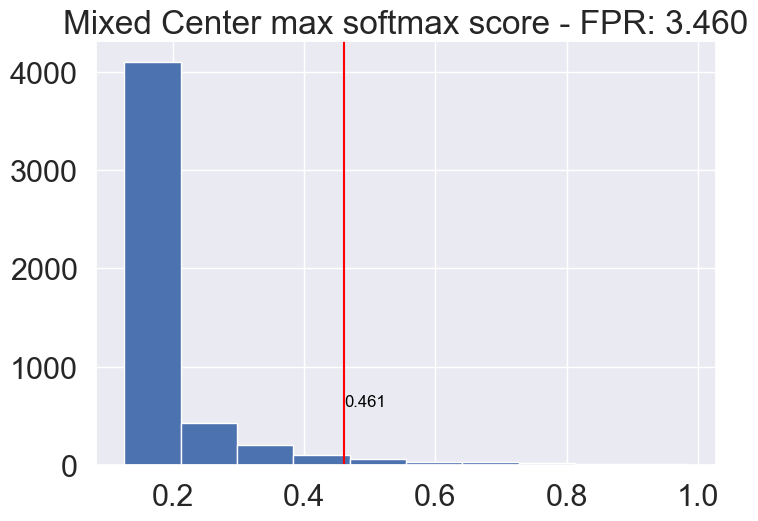

In [18]:
plt.hist(softmax_out.cpu().numpy())
plt.axvline(x = TPR95, color = 'red')
plt.text(TPR95, 600, np.round(TPR95,3), fontsize=12, color='black')
plt.title('Mixed Center max softmax score - FPR: {:.3f}'.format(100*np.mean(softmax_out.cpu().numpy() > TPR95)))

## 3. Unlike Donut

In [19]:
group_out = np.load('wafer_image/group_unlike_donut.npy')

group_out = torch.Tensor(group_out)

group_out[group_out == 255] = 1

sample_image = group_out

# 모델에 이미지 데이터 전달
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():  # 그라디언트 계산 비활성화
    output = model(sample_image.to(DEVICE))  # 모델에 이미지 데이터 전달

# 소프트맥스 함수를 적용하여 확률값 계산
softmax_output = torch.softmax(output, dim=1)

predicted_classes = torch.argmax(softmax_output, dim=1).tolist()

# 각 이미지별로 가장 큰 소프트맥스 값을 가진 값을 추출
softmax_out = torch.max(softmax_output, axis = 1).values
print(softmax_out.shape)
print(Counter(predicted_classes))

torch.Size([5000])
Counter({2: 3364, 3: 1304, 4: 242, 6: 61, 0: 15, 1: 11, 5: 3})


Text(0.5, 1.0, 'Unlike Donut max softmax score - FPR: 27.340')

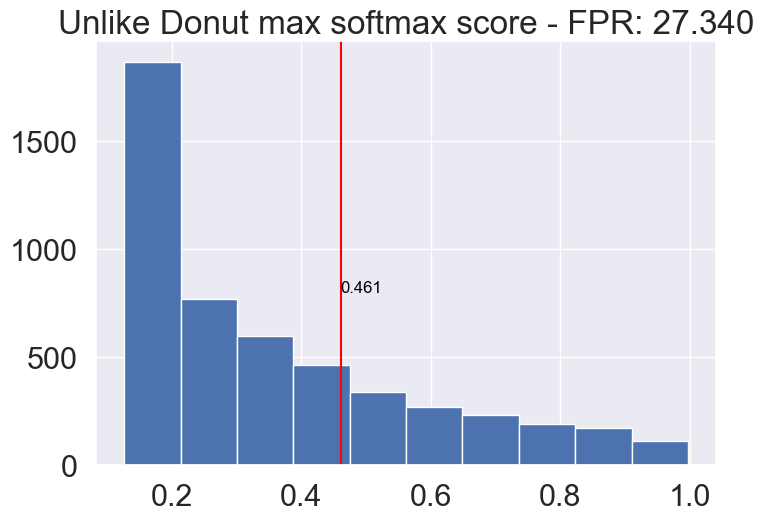

In [20]:
plt.hist(softmax_out.cpu().numpy())
plt.axvline(x = TPR95, color = 'red')
plt.text(TPR95, 800, np.round(TPR95,3), fontsize=12, color='black')
plt.title('Unlike Donut max softmax score - FPR: {:.3f}'.format(100*np.mean(softmax_out.cpu().numpy() > TPR95)))

## 4.CIFAR10

In [21]:
group_out = np.load('cifar10_test_data.npy')

group_out = torch.Tensor(group_out)

# 모델에 이미지 데이터 전달
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():  # 그라디언트 계산 비활성화
    output = model(group_out.to(DEVICE))  # 모델에 이미지 데이터 전달

# 소프트맥스 함수를 적용하여 확률값 계산
softmax_output = torch.softmax(output, dim=1)

predicted_classes = torch.argmax(softmax_output, dim=1).tolist()

# 각 이미지별로 가장 큰 소프트맥스 값을 가진 값을 추출
softmax_out = torch.max(softmax_output, axis = 1).values
print(softmax_out.shape)
print(Counter(predicted_classes))

torch.Size([10000])
Counter({2: 5427, 0: 1950, 6: 1855, 4: 644, 5: 76, 3: 38, 1: 10})


Text(0.5, 1.0, 'CIFAR10 score - FPR: 13.510')

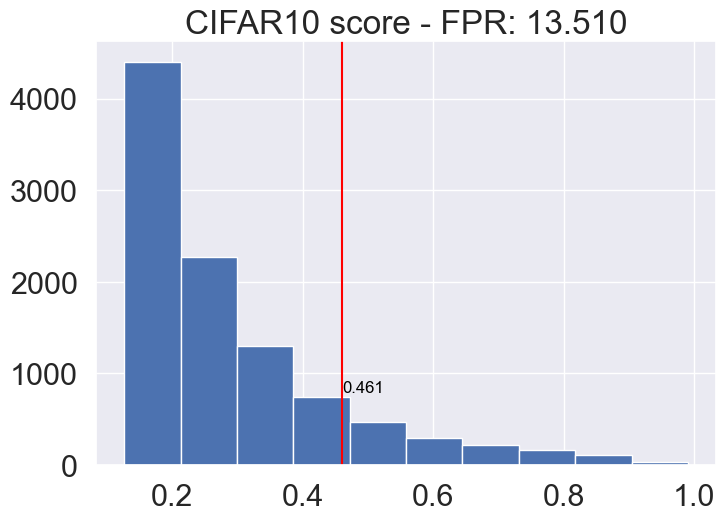

In [22]:
plt.hist(softmax_out.cpu().numpy())
plt.axvline(x = TPR95, color = 'red')
plt.text(TPR95, 800, np.round(TPR95,3), fontsize=12, color='black')
plt.title('CIFAR10 score - FPR: {:.3f}'.format(100*np.mean(softmax_out.cpu().numpy() > TPR95)))